# Latent Dirichlet Allocation (LDA) - Human Rights Abuses in Qatar Part 2

For Part 2 of this project, we basically apply advanced Topic Modelling algorithm ~ Latent Dirichlet Allocation (LDA) with TFIDFVectorizer() and Countvectorizer() and compare the results. The main objective is to derive meaningful and interpretable topics from our documents. We will also compare these results with our wordcloud topics extracted from the reports to see if there are any similarities between the document Topics and the results of the Model.

**The project Objectives for Part 2 of this project :**

**1. Determine DF cutoffs**
 - Filtering top words


**2. Find Optimal Number of Topics using Average Topic Coherence**
 - We use both CountVectorizer() and TfidfVectorizer() to check how consistent the suggested topics are.


**3. LDA with CountVectorizer()**
 - simply counts the number of times a word appears in a document (using a bag-of-words approach)
 
 
**4. LDA with TFIDFVectorizer()**
 - takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus


**5. Find Optimal parameters of Alpha and Beta**
 - We try setting different initial values for LDA generative process parameters.

### Libraries

In [26]:
import nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # for stemming
from nltk.tokenize import word_tokenize # for tokenization
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

In [27]:
import re
import math
import warnings
import itertools
import plotly.express as px # for nice plotting
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
from gensim import corpora # for: Dictionary(), word2bow()
from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer
from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM
from sklearn.decomposition import LatentDirichletAllocation # LDA implementation

In [29]:
# import dataset tokenised_data

import pickle 
with open("outputs/df_qatar.pkl", "rb") as fp:
    df_qatar = pickle.load(fp)
    
with open("outputs/topic_clean.pkl", "rb") as fp:
    topic_clean = pickle.load(fp)

In [30]:
# review dataset
df_qatar.head()

,stemmed_tokens,qatar_tokens,qatar_texts,qatar_tokens_gensim,qatar_text_gensim
0,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, r...",qatar submission un universal periodic review ...,"[qatar, submission_un, universal_periodic, rev...",qatar submission_un universal_periodic review ...
1,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, r...",qatar submission un universal periodic review ...,"[qatar, submission_un, universal_periodic, rev...",qatar submission_un universal_periodic review ...
2,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, e...",qatar submission un universal periodic eview s...,"[qatar, submission_un, universal_periodic, evi...",qatar submission_un universal_periodic eview s...
3,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, r...",qatar submission un universal periodic review ...,"[qatar, submission_un, universal_periodic, rev...",qatar submission_un universal_periodic review ...
4,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, e...",qatar submission un universal periodic eview s...,"[qatar, submission_un, universal_periodic, evi...",qatar submission_un universal_periodic eview s...


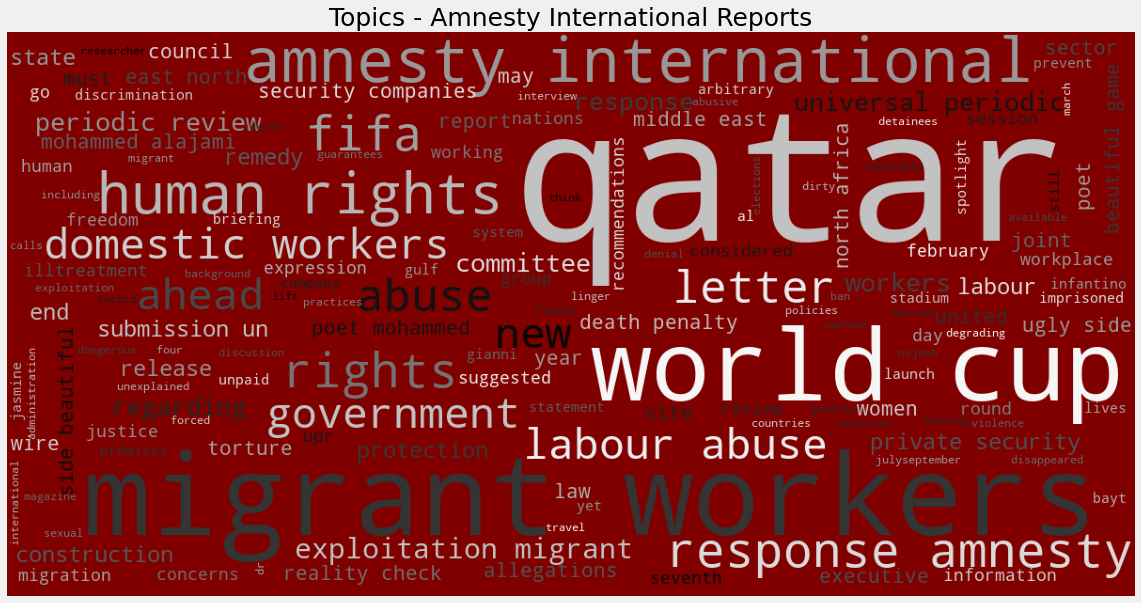

In [43]:
from wordcloud import WordCloud
cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap = 'gist_gray',
                      background_color='Maroon',
                      collocations=True,
                      contour_color='#820263',
                      contour_width=3).generate_from_text(topic_clean)
plt.figure(figsize=(18,12))
plt.imshow(cloud)
plt.axis('off')
plt.title('Topics - Amnesty International Reports', fontsize=25)
plt.show()

# 1. Considering possible DF cut-offs

In [32]:
# get tokens from dataframe
qatar_texts = df_qatar['qatar_tokens']

#create a dictionary of words
dictionary = corpora.Dictionary(qatar_texts) # using the column with preprocessed data in form of tokens 

# corpus 
corpus = [dictionary.doc2bow(text) for text in qatar_texts] # same as above

In [33]:
def DF(corpus, dictionary):
    occurence = {}

    for i in range(0,len(corpus)):
    
        #corpus from gensim library consists of so called bows
        #every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
        bow = dict(corpus[i])
    
        #dict_combined = keys are tokens' names; values are numbers of tokens' occurences in text
        bow_dict_combined = dict((dictionary[key], value) for (key, value) in bow.items())

        # creates a dictionary where keys are tokens' names and values are lists of tokens' non-zero counts in texts
        for token, count in bow_dict_combined.items():
            occurence.setdefault(token, []).append(count)

    DFdictionary = {}
        
    # based on tokens' counts dictionary woth tokens' names and IDF values is computed
    for token, counts in occurence.items():
        DFdictionary[token] = len(counts)/len(corpus)
        
    return(DFdictionary)

In [34]:
# call the function
DFdictionary = DF(corpus, dictionary)

In [35]:
# Number of unique token
len(DFdictionary)

469134

In [36]:
# Print dictionary of top 15 words - DF
dict(itertools.islice(sorted(DFdictionary.items(), key=lambda item: item[1], reverse=True), 1 ,15))

{'amnesty': 0.8898768809849521,
 'amnesty_international': 0.8173734610123119,
 'workers': 0.7113543091655267,
 'qatar': 0.6935704514363885,
 'rights': 0.6559507523939808,
 'migrant': 0.5697674418604651,
 'human': 0.5376196990424077,
 'migrant_workers': 0.5116279069767442,
 'labour': 0.5088919288645691,
 'human_rights': 0.4856361149110807,
 'law': 0.48221614227086185,
 'work': 0.46716826265389877,
 'world': 0.45896032831737343,
 'including': 0.45348837209302323}

All tokens with DF above 0.75 will be removed

# 2. Find  optimal number of topics LDA

Finding optimal number of topics in LDA using CountVectorizer and TFIDFVectorizer. Filtering with document frequency (0.75)

In [37]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

tokenizer = RegexpTokenizer(r'\w+') # tokenizer

# 1. TF count vectorizer
tf_vectorizer = CountVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(df_qatar.qatar_texts), #filtering with document frequency
                                tokenizer = tokenizer.tokenize,
)
tf = tf_vectorizer.fit_transform(df_qatar.qatar_texts) # tf
tf_feature_names = tf_vectorizer.get_feature_names()


# 2. TFIDF count vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                   max_df = 0.75, #filtering with document frequency
                                   min_df = 5/len(df_qatar.qatar_texts), #filtering with document frequency
                                   tokenizer = tokenizer.tokenize
)
tfidf = tfidf_vectorizer.fit_transform(df_qatar.qatar_texts) # tf
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [38]:
# source: https://stackoverflow.com/questions/69730428/how-do-i-find-coherence-score-for-lsa-and-lda-for-sklearn-models
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

### i) Optimizing the number of topics for LDA with CountVectorizer() applied 

In [39]:
measures_specific = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 5, 
                                    random_state = 42)
                
    lda.fit(tf)
    
    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25) # lda with CountVectorizer() , 25 topics passed 

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

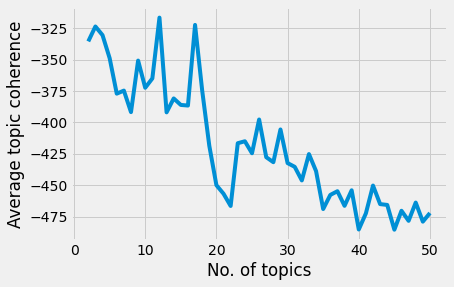

In [40]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_df_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

plt.style.use("fivethirtyeight")
plt.plot(measures_specific_df_lda['n_topics'],measures_specific_df_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [41]:
measures_specific_df_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
10,-316.569823,12
15,-322.374646,17
1,-323.616025,3
2,-330.521437,4
0,-335.493621,2
3,-348.834851,5
7,-350.761475,9
9,-364.987387,11
8,-372.404606,10


The suggested number of topics using CountVectorizer() is 12. Next recommendations are 12,17,3,4,2,5,9....


### ii) Optimizing the number of topics for LDA with TfidfVectorizer() applied

In [64]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

measures_specific = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 5, 
                                    random_state = 42)
                
    lda.fit(tfidf)
    
    avg_coherence = get_average_topic_coherence(tfidf, lda.components_, 25) # lda with TfidfVectorizer() , 25 topics passed 

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

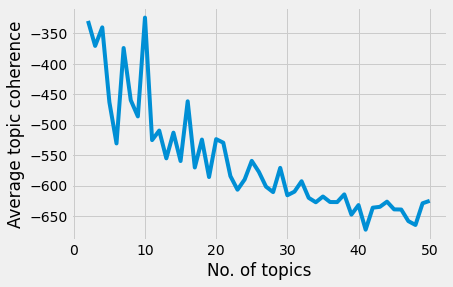

In [65]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_df_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

plt.style.use("fivethirtyeight")
plt.plot(measures_specific_df_lda['n_topics'],measures_specific_df_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [66]:
measures_specific_df_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
8,-323.929228,10
0,-329.350698,2
2,-339.930121,4
1,-370.410804,3
5,-373.869539,7
6,-459.498047,8
14,-461.402176,16
3,-462.844478,5
7,-486.255792,9


The suggested number of topics using TfidfVectorizer() is 10. Next recommendations are 10,2,4,3,7,8,16..... 

Generally, with more topics, the model can generate more meaningful and interpretable topics that are more descriptive and relevant to the documents. Also, the model can more accurately capture the diversity of the documents and provide a more representative sample of the topics present in the documents. And lastly, with more topics there are less chance of overlap between different topics


We will consider 16 topics for LDA with both TFIDF and CountVectorizer. Next, we will try 32 topics to see if we get more interpretable high quality topics while reducing over-fitting of topics.

# 3. Perfoming LDA for CountVectorizer() 

In [22]:
lda = LatentDirichletAllocation(n_components = 16, # number of topics
                                learning_method = 'online', # method used in fit(). recommended
                                learning_offset = 50.0, # this parameter downweights early iterations in online learning
                                max_iter = 5, # iterations in fit()
                                random_state = 7000)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=16, random_state=7000)

In [72]:
# 10 topics 
for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['indigenous', 'indigenous peoples', 'rights', 'peoples', 'court', 'human rights', 'human', 'workers', 'migrant', 'khalifa stadium']
Topic 1:  ['eversendai', 'khalifa stadium', 'migrant', 'workers', 'human', 'women', 'death', 'nakheel', 'rights', 'including']
Topic 2:  ['suman', 'sujan', 'taka', 'miah', 'mohammed suman miah', 'bangladeshi', 'suman miah', 'mohammed suman', 'jamal', 'welfare board']
Topic 3:  ['rights', 'human', 'human rights', 'london', 'easton', 'street', 'street london', 'easton street', 'easton street london', 'amnesty org']
Topic 4:  ['rights', 'human', 'human rights', 'un', 'fifa', 'right', 'social', 'economic', 'accessed', 'cultural']
Topic 5:  ['workers', 'qatar', 'migrant', 'labour', 'migrant workers', 'world', 'cup', 'world cup', 'work', 'rights']
Topic 6:  ['eversendai', 'barwa', 'barwa al', 'qatar', 'report', 'crc', 'fifa', 'six construct', 'overdue', 'al baraha']
Topic 7:  ['death', 'drug', 'death penalty', 'penalty', 'drugs', 'offences', 'act', 'd

- Topic 0 - Human rights for Indegenous people and migrant workers who work at Khalifa Stadium
- Topic 1 - Construction companies (Eversendai, Nakheel), death of women and migrant workers and their rights
- Topic 2 - Mohammed Suman Miah and Sujan Miah - migrants workers who died in qatar (Welfare compensation in Taka, Bangladesh currency)
- Topic 3 - East London amnesty offices
- Topic 4 - United Nations, FIFA board, rights (Social, cultural, ecnomic, human)
- Topic 5 - Migrant workers and labour rights in Qatar world cup
- Topic 6 - Construction companies (Eversendai, Six construction, Construction and Restructuring Engineering Co.(CRC)) and residential area for workers (Barwa Al Baraha)
- Topic 7 - Drug offences, drug trafficking, death penalty and execution
- Topic 8 - Abusive labour migration policies
- Topic 9 - Domestic workers, women rights and government authorities, law
- Topic 10 - Special rapporteurs overdue reports - These are overdue reports on human rights issues 
- Topic 11 - Causes of workers deaths, heat, diseases, autopsies 
- Topic 12 - Death penalty torture,  punishment, flogging
- Topic 13 - Standards for construction companies in Qatar (Eversendai, Qatar Med Centre (QMC), Nakheel, Aspire zone(Sports and wellness complex)) 
- Topic 14 - Nakheel landscapes (Real estate company in qatar), Amnesty International
- Topic 15 - International covenant and protection

In [74]:
# 32 topics
for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['rights', 'human rights', 'human', 'court', 'migrant', 'violence', 'law', 'workers', 'national', 'qatar']
Topic 1:  ['human', 'rights', 'death', 'women', 'including', 'ensure', 'human rights', 'death penalty', 'law', 'violence']
Topic 2:  ['rights', 'human', 'law', 'ratified', 'optional protocol', 'information', 'human rights', 'optional', 'death', 'convention']
Topic 3:  ['overdue', 'ratified', 'protocol', 'relating', 'geneva', 'years overdue', 'geneva conventions', 'years', 'report', 'special']
Topic 4:  ['rights', 'human', 'human rights', 'law', 'including', 'torture', 'women', 'authorities', 'people', 'treatment']
Topic 5:  ['workers', 'qatar', 'italy', 'migrant', 'employers', 'migrant workers', 'law', 'employer', 'rights', 'activists']
Topic 6:  ['fifa', 'sustainability', 'cup', 'board', 'world', 'fifa world cup', 'cup qatar', 'world cup qatar', 'fifa world', 'world cup']
Topic 7:  ['refugees', 'welcome', 'survey', 'governments', 'people', 'uk', 'would welcome', 'people

Changing from 16 to 32 topics did not results in significant change in our topics. About **4 distinct topics** were noticed

- Topic 5 - Migrants workers from ITALY and activists
- Topic 6 - FIFA world cup board
- Topic 7 - Refugees, UK and governments
- Topic 8 - Midmac Six Construct JV, a joint venture between Midmac Contracting Company & Six Construct, two largest construction companies in Qatar.
- Topic 9 - **Mohammed Alajami** held in prison and court trial, freedom of expression (He was detained in November 2011)
- Topic 20 - Migrant workers from CHINA Hong Kong, labour rules and policies
- Topic 24 - **Sexual Violence** and ill treatment against workers in Eversendai 
- Topic 28 - Name change to protect worker working at Khaifa stadium and Eversendai due to interviews conducted by Amnesty International

These topics are very dinstict and they reveal more inherent topics from documents that were not captured when only 16 topics were considered. 

However, we can also note that there is overlap on some topics for instance **Topics 2,3,10,13,22,29,31** are very similar and basically refer to ratified convetions, protocol, over due reports

# 4. Perfoming LDA for TfidfVectorizer()

In [166]:
lda = LatentDirichletAllocation(n_components = 28, # number of topics
                                learning_method = 'online', # method used in fit(). recommended
                                learning_offset = 50.0, # this parameter downweights early iterations in online learning
                                max_iter = 5, # iterations in fit()
                                random_state = 42)
lda.fit(tfidf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=28, random_state=42)

In [79]:
# 16 TOPICS
for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['workers', 'mentioned', 'pilot', 'body responsible', 'abuses facing migrant', 'nationality', 'worker representatives', 'provisions labour', 'disaggregated data', 'un']
Topic 1:  ['ratified', 'protocol', 'overdue', 'geneva conventions', 'geneva', 'relating', 'conventions relating', 'conventions', 'years overdue', 'periodic']
Topic 2:  ['qatar', 'human rights', 'among', 'hope', 'security', 'grossly', 'serbia', 'usually', 'freedom', 'international want rest']
Topic 3:  ['national law', 'accede', 'national law accede', 'implement national law', 'implement national', 'law accede', 'law', 'international criminal court', 'court implement', 'implement']
Topic 4:  ['workers', 'club world', 'companies', 'war', 'non compliances', 'world cup', 'wall', 'told', 'supreme committee', 'submission']
Topic 5:  ['workers', 'qatar', 'labour', 'migrant workers', 'migrant', 'system', 'rights', 'employers', 'fifa', 'law']
Topic 6:  ['workers', 'qatar', 'rights', 'migrant', 'labour', 'human', 'domes

Using TF-IDF, topics were not really interpretable, except for a few topics

- Topic 0 - Abuses facing migrant workers, and workers representatives. Also about disaggregated data and nationality for migrant workers
- Topic 3 - International criminal court and implementing national law
- Topic 4 - Non compliance of companies and Supreme Committee (The Supreme Committee is a governmental body in Qatar established in 2011 to ensure the successful delivery of projects for the FIFA World Cup 202)
- Topic 5 - Migrant workers, labour rights and law (similar to topic 6)
- Topic 7 - Ministry of Administrative Development, Labour and Social Affairs - moadlsa, Al Ajami court day
- Topic 11 - Residence permits and undocumented workers
- Topic 14 - Human rights committee letters to construction and Engineering companies (Krantz and SEG (Specialized Engineering Group))
- Topic 15 - Forced labour abuse in Qatar and cassation upheld in countries including Netherlands, Korea, Palentine. Cassation generally refers to any type of appeal to a higher court.


**Topic 1, 10, 12, 13** are very similar and also **Topic 5 and 6** are similar to each other. Using TidfVectorizer() with 16 topics, we are only able to extract a view distinct topics

In [81]:
# 28 TOPICS
for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['mentioned', 'new', 'pilot', 'body responsible', 'abuses facing migrant', 'worker representatives', 'provisions labour', 'disaggregated data', 'workers others', 'interna']
Topic 1:  ['ratified', 'protocol', 'geneva conventions', 'ratified entered', 'conventions relating', 'ratified optional', 'geneva conventions relating', 'ratified optional protocol', 'ratified protocol', 'protocol crc']
Topic 2:  ['ratified', 'protocol', 'forced labour', 'refugees', 'workers', 'forced', 'supreme committee', 'labour', 'qatar', 'people worldwide']
Topic 3:  ['workers', 'qatar', 'rights', 'migrant', 'labour', 'human', 'domestic', 'migrant workers', 'human rights', 'domestic workers']
Topic 4:  ['workers', 'qatar', 'world cup', 'migrant', 'world', 'migrant workers', 'migration spotlight', 'migration spotlight qatar', 'featured report', 'sector ahead']
Topic 5:  ['sc', 'workers', 'filed', 'qatar', 'less', 'entry exit', 'covenant civil', 'trade unions', 'worker india', 'vulnerable']
Topic 6:  ['

Using 28 topics did not results in significant change in our topics. About 7 NEW distinct topics were noticed

Even after considering more topics (28), still most topics are not interpretable. And also, there is NOT much similarity between TfidfVectorizer() and CountVectorizer() results in terms of TOPICS.

Below are some of the dinstict Topics after changing from 16 to 28 topics

- Topic 5 - Vulnerable workers from India and Trade Union
- Topic 6 - Detainees, Private security companies, migrant workers
- Topic 17 - **Employers sponsorship of exit permit** to migrant workers
- Topic 18 - Illtreatment and torture of Poet Al Ajami
- Topic 20 - Labour exploitation and torture of **migrant workers from Africa**
- Topic 24 - Low income migrants from kathmandu (kathmandu Capital of Nepal), Malaysia
- Topic 27 - Failing to pay **outstanding Wage**
- Topic 25 - **Kafala system** violating migrant workers rights 
 (Kafali system is a sponsorship system that governs the employment of migrant workers in qatar. Migrant workers are tied to their sponsor and are not allowed to change jobs or leave the country without the sponsor's permission.)


# 5. Optimal  𝛼 and  𝛽 parameters

We try setting different initial values for LDA generative process parameters. We analyse to see if we can get more improved results from our model

In [167]:
params = []
for alpha in [0.0001, 0.001, 0.01, 0.05, 0.1]:
    for beta in [0.0001, 0.001, 0.01, 0.05, 0.1]:
        for vectorizer_name in ['tf','tf-idf']:
            
            if(vectorizer_name == 'tf'):
                print(alpha, beta, 'tf')
                lda = LatentDirichletAllocation(n_components = 28, 
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online', 
                                                learning_offset = 50.0,
                                                max_iter = 5, 
                                                random_state = 42)
                lda.fit(tf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf', avg_coherence])
                    
            if(vectorizer_name == 'tf-idf'):
                print(alpha, beta, 'tf-idf')
                lda = LatentDirichletAllocation(n_components = 28, 
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online', 
                                                learning_offset = 50.0,
                                                max_iter = 5, 
                                                random_state = 42)
                lda.fit(tfidf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf-idf', avg_coherence])

0.0001 0.0001 tf
0.0001 0.0001 tf-idf
0.0001 0.001 tf
0.0001 0.001 tf-idf
0.0001 0.01 tf
0.0001 0.01 tf-idf
0.0001 0.05 tf
0.0001 0.05 tf-idf
0.0001 0.1 tf
0.0001 0.1 tf-idf
0.001 0.0001 tf
0.001 0.0001 tf-idf
0.001 0.001 tf
0.001 0.001 tf-idf
0.001 0.01 tf
0.001 0.01 tf-idf
0.001 0.05 tf
0.001 0.05 tf-idf
0.001 0.1 tf
0.001 0.1 tf-idf
0.01 0.0001 tf
0.01 0.0001 tf-idf
0.01 0.001 tf
0.01 0.001 tf-idf
0.01 0.01 tf
0.01 0.01 tf-idf
0.01 0.05 tf
0.01 0.05 tf-idf
0.01 0.1 tf
0.01 0.1 tf-idf
0.05 0.0001 tf
0.05 0.0001 tf-idf
0.05 0.001 tf
0.05 0.001 tf-idf
0.05 0.01 tf
0.05 0.01 tf-idf
0.05 0.05 tf
0.05 0.05 tf-idf
0.05 0.1 tf
0.05 0.1 tf-idf
0.1 0.0001 tf
0.1 0.0001 tf-idf
0.1 0.001 tf
0.1 0.001 tf-idf
0.1 0.01 tf
0.1 0.01 tf-idf
0.1 0.05 tf
0.1 0.05 tf-idf
0.1 0.1 tf
0.1 0.1 tf-idf


In [168]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
params_df = pd.DataFrame(params).rename(columns={
    0: 'alpha', 1: 'beta', 2: 'vectorizer', 3: 'avg_coherence'
})

In [169]:
params_df.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,alpha,beta,vectorizer,avg_coherence
30,0.0500,0.0001,tf,-429.022708
34,0.0500,0.0100,tf,-429.517007
32,0.0500,0.0010,tf,-430.196705
0,0.0001,0.0001,tf,-430.471584
10,0.0010,0.0001,tf,-431.188675
2,0.0001,0.0010,tf,-431.268358
12,0.0010,0.0010,tf,-431.521401
40,0.1000,0.0001,tf,-432.288367
42,0.1000,0.0010,tf,-432.308331


In [170]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

Consindering LDA with TF values assuming 28 topics, the value of alpha parameter is suggested at **0.05** and the value of beta suggested at **0.0001**. Average coherence is around **-429.022**

In [171]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf-idf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

Consindering LDA with TF-IDF values assuming 28 topics, the value of alpha parameter is suggested at **0.001** and the value of beta suggested at **0.05**. Average coherence of around **-598.24**

### Change LDA generative process parameters for TF.

In [172]:
lda = LatentDirichletAllocation(n_components = 28, # let us stay with 30, as that is what topic coherence initially recommended 
                                doc_topic_prior = 0.05, #alpha
                                topic_word_prior = 0.0001,  #beta
                                learning_method = 'online', 
                                learning_offset = 50.0,
                                max_iter = 5, 
                                random_state = 7000)
lda.fit(tf) # TF for now

for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['rights', 'court', 'interview qatar name', 'workers', 'protect identity amnesty', 'migrant', 'name changed protect', 'human', 'al ajami', 'qatar']
Topic 1:  ['death', 'bahadur', 'yam', 'death certificate', 'tul', 'case study case', 'study case', 'private prime lives', 'private prime', 'provides information underlying']
Topic 2:  ['rights', 'information', 'ratified', 'human', 'death', 'law', 'people', 'usa', 'optional protocol', 'convention']
Topic 3:  ['protocol', 'ratified', 'rights', 'relating', 'convention', 'geneva', 'geneva conventions', 'optional protocol', 'conventions', 'optional']
Topic 4:  ['rights', 'special', 'rapporteur', 'special rapporteur', 'human rights', 'human', 'initial report', 'initial', 'ratified', 'including']
Topic 5:  ['workers', 'qatar', 'identity amnesty international', 'name changed protect', 'identity amnesty', 'law', 'migrant', 'death', 'protect identity amnesty', 'interview qatar name']
Topic 6:  ['fifa', 'cup', 'world', 'world cup', 'human ri

**There is a bit of a change in our results. Some additional topics were noted i.e**

- Topic 1 - **Yam Bahadur (from Nepal)** death and death certificate. He who was one of the migrant worker who died in Qatar 
- Topic 20 - Abusive labour migrations from **Hong Kong China** and UN committee for migrants
- Topic 23 - **Kidney**, autopsies, disease, stress impact and **Professor Vivekanand Jha**. Professor Vivekanand Jha is the Executive Director at The George Institute for Global Health, India, Chair of Global Kidney Health, Faculty of Medicine, Imperial College of London

### Change LDA generative process parameters for TFIDF.

In [176]:
lda = LatentDirichletAllocation(n_components = 28, # let us stay with 30, as that is what topic coherence initially recommended 
                                doc_topic_prior = 0.001,
                                topic_word_prior = 0.05,
                                learning_method = 'online', 
                                learning_offset = 50.0,
                                max_iter = 5, 
                                random_state = 42)
lda.fit(tfidf) # TF-IDF now

for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['mentioned', 'new', 'pilot', 'body responsible', 'abuses facing migrant', 'worker representatives', 'provisions labour', 'disaggregated data', 'workers others', 'interna']
Topic 1:  ['ratified', 'geneva conventions', 'protocol', 'ratified entered', 'conventions relating', 'geneva conventions relating', 'ratified protocol', 'relating status', 'protocol crc', 'ratified optional']
Topic 2:  ['forced labour', 'forced', 'workers', 'supreme committee', 'refugees', 'people worldwide', 'qatar', 'krantz', 'labour', 'bad']
Topic 3:  ['workers', 'qatar', 'rights', 'migrant', 'labour', 'human', 'domestic', 'migrant workers', 'human rights', 'domestic workers']
Topic 4:  ['workers', 'qatar', 'migrant', 'world cup', 'migrant workers', 'world', 'migration spotlight', 'migration spotlight qatar', 'featured report', 'sector ahead']
Topic 5:  ['sc', 'torture', 'workers', 'filed', 'qatar', 'torture ill', 'entry exit', 'covenant civil', 'vulnerable', 'accommodation standards']
Topic 6:  ['worke

Results are a bit more interpretable than before optimising parameters and topics are a bit dinstict.

# Conclusion

Results of the model are impressive as we are able to derive meaningful and interpretable results from **Latent Dirichlet Allocation (LDA)** model using both Tfidf and CountVectorizer(). Between the two, CountVectorizer() seemed to derive more interpretable results and dinstict Topics. However TfidfVectorizer() has other important topics that are NOT included in the CountVectorizer(). 

Comparing LDA model results to *WordCloud Visualisation of document topics*, we realise that Topics derived from the model included words such as **Migrant workers, Human rights, Abuse, illtreatment, Poet Mohammed, FIFA, Women, Private Security, Mohammed Alajali, Death penalty, UN, Domestic workers**. Therefore, we can conclude that there is similarity between the documents topics and the results of the Model

**Other Topic Modelling algorithms will used to see if we can get better results from LDA i.e., Latent Semantic Analysis (LSA).**